In [1]:
import pandas as pd
import numpy as np
import datetime
from itertools import product
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def interpolateFun0(x):
    """Original script author's function rewritten in Python.
    The author interpolates between two known values by averaging them. We
    can think of this as 0th order interpolation. """

    ## TODO: This function could use some optimization. The R version is much faster...
    x = x.reset_index(drop=True)
    g = x['outcome'] ## g should be a list or a pandas Series.
    if g.shape[0] < 3: ## If we have at most two rows.
        x['filled'] = g ## Will be replaced by a mean.
        return x
    missing_index = g.isnull()
    borders = np.append([g.index[0]], g[~missing_index].index, axis=0)
    borders = np.append(borders, [g.index[-1]+1], axis=0)
    forward_border = borders[1:]
    backward_border = borders[:-1]
    forward_border_g = g[forward_border]
    backward_border_g = g[backward_border]
    ## Interpolate borders.
    ## TODO: Why does the script author use the value 0.1?
    border_fill = 0.1
    forward_border_g[forward_border_g.index[-1]] = abs(forward_border_g[forward_border_g.index[-2]]-border_fill)
    backward_border_g[backward_border_g.index[0]] = abs(forward_border_g[forward_border_g.index[0]]-border_fill)
    times = forward_border-backward_border
    forward_x_fill = np.repeat(forward_border_g, times).reset_index(drop=True)
    backward_x_fill = np.repeat(backward_border_g, times).reset_index(drop=True)
    vec = (forward_x_fill+backward_x_fill)/2
    g[missing_index] = vec[missing_index] ## Impute missing values only.
    x['filled'] = g
    return x

In [3]:
ppl = pd.read_csv('../input/people.csv')

# Convert booleans to integers.
p_logi = ppl.select_dtypes(include=['bool']).columns
ppl[p_logi] = ppl[p_logi].astype('int')
del p_logi

# Transform date.
ppl['date'] = pd.to_datetime(ppl['date'])

# Load activities.--------------------------------------------------------------
# Read and combine.
activs = pd.read_csv('../input/act_train.csv')
TestActivs = pd.read_csv('../input/act_test.csv')
TestActivs['outcome'] = np.nan ## Add the missing column to the test set.
activs = pd.concat([activs, TestActivs], axis=0) ## Append train and test sets.
del TestActivs

# Extract only required variables.
activs = activs[['people_id', 'outcome', 'activity_id', 'date']] ## Let's look at these columns only.

# Merge people data into activities.
## This keeps all the rows from activities.
## TODO: We are not using rows from ppl who have no activities...
d1 = pd.merge(activs, ppl, on='people_id', how='right')

## These are the indices of the rows from the test set.
testset = ppl[ppl['people_id'].isin(d1[d1['outcome'].isnull()]['people_id'])].index

d1['activdate'] = pd.to_datetime(d1['date_x'])

del activs

# Prepare grid for prediction. -------------------------------------------------

# Create all group_1/day grid.
minactivdate = min(d1['activdate'])
maxactivdate = max(d1['activdate'])

## Make a list of all days from min to max.
alldays = [maxactivdate - datetime.timedelta(days=x) for x in range(0, (maxactivdate - minactivdate).days+1)][::-1]

## Take the values of group_1 from the rows of d1 which do not belong to the test set.
grid_left = set(d1[~d1['people_id'].isin(ppl.iloc[testset]['people_id'])]['group_1'])
## Take cartesian product between the above variable and the list of all days.
## I think in the original script author thinks of the values in group_1 as companies.
allCompaniesAndDays = pd.DataFrame.from_records(product(grid_left, alldays))

# Nicer names.
allCompaniesAndDays.columns = ['group_1', 'date_p']

# Sort it.
allCompaniesAndDays.sort_values(['group_1', 'date_p'], inplace=True)

## This is what allCompaniesAndDays looks like so far.
"""
>>> allCompaniesAndDays.sample(n=10)
              group_1     date_p
10318543  group 14386 2023-08-09
3470112    group 8767 2022-08-25
5542924   group 30061 2023-01-11
2328370   group 39750 2022-09-10
7764760    group 1175 2022-12-12
4788523    group 3788 2023-07-25
5545711   group 12085 2022-10-13
859359    group 28900 2023-07-21
11188454  group 21110 2023-02-14
9277889   group 26980 2023-08-07
"""

# What are values on days where we have data?
## For a combination of group_1 and activdate, calculate the mean of the outcome variable.
meanbycomdate = d1[~d1['people_id'].isin(ppl.iloc[testset]['people_id'])].\
    groupby(['group_1', 'activdate'])['outcome'].agg('mean')
## Convert the calculation into a proper DataFrame.
meanbycomdate = meanbycomdate.to_frame().reset_index()

# Add them to full data grid.
allCompaniesAndDays = pd.merge(allCompaniesAndDays, meanbycomdate, left_on=['group_1', 'date_p'],\
                                right_on=['group_1', 'activdate'], how='left')
allCompaniesAndDays.drop('activdate', axis=1, inplace=True)
allCompaniesAndDays.sort_values(['group_1', 'date_p'], inplace=True)

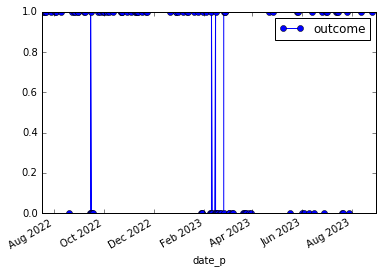

In [35]:
df = allCompaniesAndDays[(allCompaniesAndDays.group_1 == 'group 102') | (allCompaniesAndDays.group_1 == 'group 1000')]
df.plot(x='date_p',y='outcome',marker='o')
# df[df.outcome.notnull()]

In [29]:
allCompaniesAndDays.group_1.unique()

array(['group 1', 'group 10', 'group 100', ..., 'group 9996', 'group 9998',
       'group 9999'], dtype=object)

In [42]:
k = df.groupby('group_1').apply(lambda x: x.reset_index(drop=True))

In [44]:
k

group_1     date_p  outcome
group_1                                       
group 1000 0    group 1000 2022-07-17      NaN
           1    group 1000 2022-07-18      NaN
           2    group 1000 2022-07-19      NaN
           3    group 1000 2022-07-20      NaN
           4    group 1000 2022-07-21      NaN
           5    group 1000 2022-07-22      NaN
           6    group 1000 2022-07-23      NaN
           7    group 1000 2022-07-24      NaN
           8    group 1000 2022-07-25      NaN
           9    group 1000 2022-07-26      NaN
           10   group 1000 2022-07-27      NaN
           11   group 1000 2022-07-28      NaN
           12   group 1000 2022-07-29      NaN
           13   group 1000 2022-07-30      NaN
           14   group 1000 2022-07-31      NaN
           15   group 1000 2022-08-01      NaN
           16   group 1000 2022-08-02      NaN
           17   group 1000 2022-08-03      NaN
           18   group 1000 2022-08-04      NaN
           19   group 1000 2022-08-05      NaN
           20   group 1000 2022-08-06      NaN
           21   group 1000 2022-08-07      NaN
           22   group 1000 2022-08-08      NaN
           23   group 1000 2022-08-09      NaN
           24   group 1000 2022-08-10      NaN
           25   group 1000 2022-08-11      NaN
           26   group 1000 2022-08-12      NaN
           27   group 1000 2022-08-13      NaN
           28   group 1000 2022-08-14      NaN
           29   group 1000 2022-08-15      NaN
...                    ...        ...      ...
group 102  381   group 102 2023-08-02      NaN
           382   group 102 2023-08-03      NaN
           383   group 102 2023-08-04      NaN
           384   group 102 2023-08-05      NaN
           385   group 102 2023-08-06      NaN
           386   group 102 2023-08-07      NaN
           387   group 102 2023-08-08      NaN
           388   group 102 2023-08-09      NaN
           389   group 102 2023-08-10      NaN
           390   group 102 2023-08-11      NaN
           391   group 102 2023-08-12      NaN
           392   group 102 2023-08-13      NaN
           393   group 102 2023-08-14      NaN
           394   group 102 2023-08-15      NaN
           395   group 102 2023-08-16      NaN
           396   group 102 2023-08-17      NaN
           397   group 102 2023-08-18      NaN
           398   group 102 2023-08-19      NaN
           399   group 102 2023-08-20      NaN
           400   group 102 2023-08-21      NaN
           401   group 102 2023-08-22      NaN
           402   group 102 2023-08-23      NaN
           403   group 102 2023-08-24      NaN
           404   group 102 2023-08-25      NaN
           405   group 102 2023-08-26      NaN
           406   group 102 2023-08-27      NaN
           407   group 102 2023-08-28      NaN
           408   group 102 2023-08-29      NaN
           409   group 102 2023-08-30      NaN
           410   group 102 2023-08-31      NaN

[822 rows x 3 columns]

In [47]:
g = k['outcome'] ## g should be a list or a pandas Series.
missing_index = g.isnull()
borders = np.append([g.index[0]], g[~missing_index].index, axis=0)
borders = np.append(borders, [g.index[-1]+1], axis=0)

ValueError: all the input arrays must have same number of dimensions

In [52]:
g[~missing_index].index

MultiIndex(levels=[[u'group 1000', u'group 102'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,